In [1]:
# !git clone https://github.com/lukemelas/EfficientNet-PyTorch
%cd /app/_data/EfficientNet-PyTorch
!pip install -e .

/app/_data/EfficientNet-PyTorch
Obtaining file:///app/_data/EfficientNet-PyTorch
  Preparing metadata (setup.py) ... done
  Attempting uninstall: efficientnet-pytorch
    Found existing installation: efficientnet-pytorch 0.7.1
    Can't uninstall 'efficientnet-pytorch'. No files were found to uninstall.
  Running setup.py develop for efficientnet-pytorch
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install torchmetrics

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
import ast
import glob
import json
import os
import re
import shutil
import sys

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from torchvision.ops import box_iou
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import torchmetrics
from IPython.display import clear_output
from sklearn.model_selection import (
    GroupKFold,
    KFold,
    StratifiedGroupKFold,
    StratifiedKFold,
)
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image

In [4]:
TRAIN_DF_PART = "/app/_data/tensorflow-great-barrier-reef/train.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 38
DEVICE

'cuda'

## Dataset

In [5]:
df = pd.read_csv(TRAIN_DF_PART)
df["img_path"] = (
    "/app/_data/tensorflow-great-barrier-reef/train_images/video_"
    + df.video_id.astype("str")
    + "/"
    + df.video_frame.astype("str")
    + ".jpg"
)
df["annotations"] = df["annotations"].apply(lambda x: ast.literal_eval(x))
df["len_annotation"] = df["annotations"].str.len()
df["image_id"] = df["image_id"].str.replace("-", "_", regex=True)
df["new_img_path"] = f"/app/_data/images/" + df["image_id"] + ".jpg"
df["label"] = df["len_annotation"].apply(lambda x: 0 if x == 0 else 1)
df["no_label"] = df["len_annotation"].apply(lambda x: True if x == 0 else False)

In [6]:
df["label_change"] = df["label"] & df["no_label"].shift(1) & df["no_label"].shift(
    2
) | df["no_label"] & df["label"].shift(1) & df["label"].shift(2)
df["sequense_change"] = df["sequence"] != df["sequence"].shift(1)
df["start_subseq"] = df["sequense_change"] | df["label_change"]
df.loc[df.index[-1], "start_subseq"] = True
df["start_subseq"].sum()

138

In [7]:
start_idx = 0
for subsequence_id, end_idx in enumerate(df[df["start_subseq"]].index):
    df.loc[start_idx:end_idx, "subsequence_id"] = subsequence_id
    start_idx = end_idx

df["subsequence_id"] = df["subsequence_id"].astype(int)
df["subsequence_id"].nunique()

137

In [8]:
cut_df = pd.read_csv("/app/_data/cut_df.csv")
cut_df.sample(10)

,image_id,new_img_id,label,bboxes,n_bboxes,npy_path
24934,0_7855,0_7855_1,0,NaN,0,/app/_data/npy_380/0_7855_1.npy
43106,1_404,1_404_3,0,NaN,0,/app/_data/npy_380/1_404_3.npy
24212,0_7764,0_7764_7,0,NaN,0,/app/_data/npy_380/0_7764_7.npy
156880,2_10574,2_10574_5,0,NaN,0,/app/_data/npy_380/2_10574_5.npy
96977,2_422,2_422_6,0,NaN,0,/app/_data/npy_380/2_422_6.npy
91841,1_11155,1_11155_6,0,NaN,0,/app/_data/npy_380/1_11155_6.npy
109461,2_1983,2_1983_2,0,NaN,0,/app/_data/npy_380/2_1983_2.npy
35414,0_11622,0_11622_6,0,NaN,0,/app/_data/npy_380/0_11622_6.npy
87468,1_10609,1_10609_1,0,NaN,0,/app/_data/npy_380/1_10609_1.npy
95641,2_255,2_255_6,0,NaN,0,/app/_data/npy_380/2_255_6.npy


In [9]:
cut_df["negative"] = cut_df["label"].replace({1: 0, 0: 1})

In [10]:
cut_df = cut_df.merge(
    df[["image_id", "sequence", "subsequence_id"]], on="image_id", how="left"
)

In [11]:
n_splits = 6
kf = GroupKFold(n_splits=n_splits)
list_train_ids = []
list_val_ids = []
for kfold, (train_idx, val_idx) in enumerate(
    kf.split(cut_df, y=cut_df.negative, groups=cut_df.sequence)
):
    list_train_ids.append(train_idx)
    list_val_ids.append(val_idx)
    print(
        kfold,
        cut_df.loc[list_train_ids[kfold]].query("negative==0").shape[0],
        cut_df.loc[list_val_ids[kfold]].query("negative==0").shape[0],
        cut_df.loc[list_train_ids[kfold]].query("negative==0").shape[0]
        / (cut_df.loc[list_val_ids[kfold]].query("negative==0").shape[0] + 1),
    )

0 9120 491 18.536585365853657
1 9580 31 299.375
2 7470 2141 3.4873949579831933
3 5622 3989 1.4090225563909775
4 7990 1621 4.926017262638718
5 8273 1338 6.1784914115011205


In [12]:
KFOLD = 5
cut_df.loc[list_train_ids[KFOLD]]["sequence"].unique()
cut_df.loc[list_train_ids[KFOLD]].shape
cut_df.loc[list_val_ids[KFOLD]]["sequence"].unique()
cut_df.loc[list_val_ids[KFOLD]].shape

array([40258, 45518, 45015, 53708,   996, 44160, 15827, 29424,  8503,
       18048, 17665, 60754, 37114, 26651, 22643, 29859])

(132393, 9)

array([59337,  8399, 35305, 60510])

(25874, 9)

In [13]:
print(
    KFOLD,
    cut_df.loc[list_train_ids[KFOLD]].query("negative==0").shape[0],
    cut_df.loc[list_val_ids[KFOLD]].query("negative==0").shape[0],
    cut_df.loc[list_train_ids[KFOLD]].query("negative==0").shape[0]
    / cut_df.loc[list_val_ids[KFOLD]].query("negative==0").shape[0],
)

5 8273 1338 6.183109118086697


# Dataloader

In [14]:
transform = A.Compose(
    [
        A.Blur(blur_limit=3, p=0.05),
        A.MedianBlur(blur_limit=3, p=0.05),
        A.ToGray(p=0.01),
        A.RandomBrightnessContrast(
            brightness_limit=0.05,
            contrast_limit=0.05,
            brightness_by_max=True,
            p=0.1,
        ),
        A.RandomGamma(p=0.05),
        A.ImageCompression(quality_lower=95, p=0.05),
        A.Sharpen(alpha=(0.2, 0.3), lightness=(0.5, 1.0), p=0.05),
        A.HueSaturationValue(
            hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.05
        ),
        A.RGBShift(p=0.05),
        A.Flip(p=0.3),
        A.ShiftScaleRotate(
            shift_limit=0.2, scale_limit=[0.1, 0.2], rotate_limit=[10, 45], p=0.01
        ),
        A.RandomRain(
            slant_lower=-10,
            slant_upper=10,
            drop_length=20,
            drop_width=1,
            drop_color=(200, 200, 200),
            blur_value=7,
            brightness_coefficient=0.6,
            rain_type="drizzle",
            p=0.05,
        ),
    ],
)

In [15]:
class CustomImageDataset(Dataset):
    def __init__(
        self,
        df,
        img_size,
        label_col="label",
        shuffle=False,
        augment=True,
        transform_fn=None,
    ):
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        self.label_col = label_col
        self.shuffle = shuffle
        self.augment = augment
        self.transform_fn = transform_fn
        self.to_tens = transforms.Compose([transforms.ToTensor()])
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, ix):
        img_path = self.df.loc[ix, "npy_path"]
        img = np.load(img_path)
        label = self.df.loc[ix, self.label_col]
        if img.shape[:2] != self.img_size:
            img = np.resize(img, self.img_size)

        if self.augment:
            img = self.transform_fn(image=img)["image"]
        img = img - img.min()
        img = img / img.max()
        img = img.transpose(2, 0, 1).astype("float32")
        return img, label.astype("int8")

In [16]:
train = pd.concat(
    [
        cut_df.loc[list_train_ids[KFOLD]].query("negative==0"),
        cut_df.loc[list_train_ids[KFOLD]]
        .query("negative==1")
        .sample(
            cut_df.loc[list_train_ids[KFOLD]].query("negative==0").shape[0]*2,
            random_state=SEED,
        ),
    ],
    ignore_index=True,
)
val = pd.concat(
    [
        cut_df.loc[list_val_ids[KFOLD]].query("negative==0"),
        cut_df.loc[list_val_ids[KFOLD]]
        .query("negative==1")
        .sample(
            cut_df.loc[list_val_ids[KFOLD]].query("negative==0").shape[0]*9,
            random_state=SEED,
        ),
    ],
    ignore_index=True,
)

In [17]:
val.query("negative==1").shape
val.query("negative==0").shape

(12042, 9)

(1338, 9)

In [18]:
train.query("negative==1").shape
train.query("negative==0").shape

(16546, 9)

(8273, 9)

In [19]:
train_gen = CustomImageDataset(
    df=train,
    img_size=(380, 380),
    label_col="negative",
    shuffle=True,
    augment=True,
    transform_fn=transform,
)
val_gen = CustomImageDataset(
    df=val,
    img_size=(380, 380),
    label_col="negative",
    shuffle=True,
    augment=False,
    transform_fn=transform,
)

In [20]:
img, label = train_gen.__getitem__(55)

In [21]:
label

0

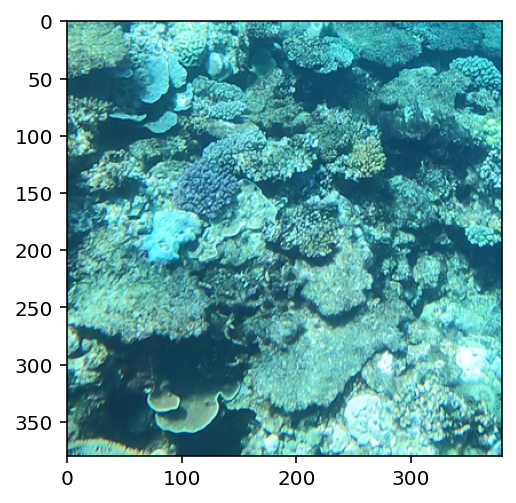

In [22]:
plt.imshow(img.transpose(1, 2, 0))

# model

In [26]:
from efficientnet_pytorch import EfficientNet

efficientnet = EfficientNet.from_pretrained('efficientnet-b4')

for param in efficientnet.parameters():
    efficientnet.requires_grad = True

efficientnet._fc

in_features = efficientnet._fc.in_features
efficientnet._fc = torch.nn.Linear(in_features, 1)
efficientnet._fc
efficientnet = efficientnet.to(DEVICE)

# train

In [27]:
train_dataloader = DataLoader(train_gen, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_gen, batch_size=64, shuffle=True)

In [28]:
num_steps = len(train_dataloader)
optimizer = torch.optim.Adam(efficientnet.parameters(), lr=0.0005)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode="min", factor=0.5, patience=5, verbose=True
)
loss_fn = torch.nn.BCELoss()

In [29]:
train_metrics = torchmetrics.MetricCollection(
    [
        torchmetrics.Accuracy(compute_on_step=False),
        torchmetrics.Precision(compute_on_step=False),
        torchmetrics.Recall(compute_on_step=False),
        torchmetrics.F1Score(compute_on_step=False),
    ]
)
val_metrics = torchmetrics.MetricCollection(
    [
        torchmetrics.Accuracy(compute_on_step=False),
        torchmetrics.Precision(compute_on_step=False),
        torchmetrics.Recall(compute_on_step=False),
        torchmetrics.F1Score(compute_on_step=False),
    ]
)

In [30]:
def train_loop(
    model,
    dataloader,
    optimizer,
    device,
    loss_fn,
    metric_fn,
    act_fn=torch.nn.Sigmoid(),
):
    train_loss = []
    model = model.train()
    for (imgs, targets) in tqdm(dataloader):
        imgs = imgs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = act_fn(model(imgs))
        loss = loss_fn(output.squeeze(), targets.float())
        train_loss.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        metric_fn.to(device)(output.squeeze(), targets)
    met = metric_fn.compute()
    acc = met["Accuracy"].detach().cpu().numpy()
    prec = met["Precision"].detach().cpu().numpy()
    recall = met["Recall"].detach().cpu().numpy()
    f1 = met["F1Score"].detach().cpu().numpy()
    metric_fn.reset()
    mean_train_loss = np.array(train_loss).mean()

    print(
        f"Train loss: {mean_train_loss}, accuracy: {acc}, recall: {recall}, precision {prec}, f1score: {f1}"
    )
    return mean_train_loss, acc, recall, prec, f1


def eval_loop(model, dataloader, device, loss_fn, metric_fn, act_fn=torch.nn.Sigmoid()):
    model = model.eval()
    val_labels = []
    val_outputs = []
    val_loss = []
    with torch.no_grad():
        for (imgs, targets) in tqdm(dataloader):
            val_labels.extend(targets.numpy().tolist())
            imgs = imgs.to(device)
            targets = targets.to(device)
            output = act_fn(model(imgs))
            loss = loss_fn(output.squeeze(), targets.float())
            val_outputs.extend(output.detach().cpu().numpy().tolist())
            val_loss.append(loss.detach().cpu().numpy())
            metric_fn.to(device)(output.squeeze(), targets)
    met = metric_fn.compute()
    acc = met["Accuracy"].detach().cpu().numpy()
    prec = met["Precision"].detach().cpu().numpy()
    recall = met["Recall"].detach().cpu().numpy()
    f1 = met["F1Score"].detach().cpu().numpy()
    metric_fn.reset()
    mean_val_loss = np.array(val_loss).mean()

    print(
        f"Val loss: {mean_val_loss}, accuracy: {acc}, recall: {recall}, precision {prec}, f1score: {f1}"
    )
    return val_outputs, val_labels, mean_val_loss, acc, recall, prec, f1

In [31]:
# !pip install --upgrade wandb
# clear_output()
import wandb

wandb.login()

wandb: Currently logged in as: tatanko (use `wandb login --relogin` to force relogin)


True

In [32]:
wandb.init(project="effnet_luk")

In [33]:
# Magic
wandb.watch(efficientnet)

[]

In [ ]:
best_loss = 10
best_acc = 0
best_recall = 0
best_precision = 0
best_f1 = 0
n = 15
for epoch in range(100):
    print(
        f"==================================================================== epoch {epoch} ===================================================================="
    )
    mean_train_loss, train_acc, train_recall, train_prec, train_f1 = train_loop(
        model=efficientnet,
        dataloader=train_dataloader,
        optimizer=optimizer,
        device=DEVICE,
        loss_fn=loss_fn,
        metric_fn=train_metrics,
        act_fn=torch.nn.Sigmoid(),
    )

    (
        val_outputs,
        val_labels,
        mean_val_loss,
        val_acc,
        val_recall,
        val_prec,
        val_f1,
    ) = eval_loop(
        model=efficientnet,
        dataloader=val_dataloader,
        device=DEVICE,
        loss_fn=loss_fn,
        metric_fn=val_metrics,
        act_fn=torch.nn.Sigmoid(),
    )
    wandb.log(
        {
            "train_loss": mean_train_loss,
            "train_accuracy": train_acc,
            "train_recall": train_recall,
            "train_precision": train_prec,
            "train_f1score": train_f1,
            "val_loss": mean_val_loss,
            "val_accuracy": val_acc,
            "val_recall": val_recall,
            "val_precision": val_prec,
            "val_f1score": val_f1,
        }
    )
    if mean_val_loss < best_loss:
        best_loss = mean_val_loss
        torch.save(
            {
                "epoch": {epoch},
                "model_state_dict": efficientnet.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss_fn,
                "mean_loss": mean_val_loss,
            },
            f"/app/_data/eff_luk/model_1.pth",
        )
        n = 15
    else:
        n -= 1
    if val_recall > best_recall:
        best_recall = val_recall
        torch.save(
            {
                "epoch": {epoch},
                "model_state_dict": efficientnet.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss_fn,
                "mean_loss": mean_val_loss,
            },
            f"/app/_data/eff_luk/model_best_rec.pth",
        )
    if n == 0:
        print('EarlyStopping')
        break
    sched.step(mean_val_loss)

==================================================================== epoch 0 ====================================================================


100% 776/776 [08:11<00:00,  1.58it/s]


Train loss: 0.23885971307754517, accuracy: 0.8973770141601562, recall: 0.9378097653388977, precision 0.9108893275260925, f1score: 0.9241535067558289


100% 210/210 [01:39<00:00,  2.12it/s]


Val loss: 0.6496097445487976, accuracy: 0.8680866956710815, recall: 0.9085699915885925, precision 0.9427832961082458, f1score: 0.9253605008125305
==================================================================== epoch 1 ====================================================================


100% 776/776 [08:12<00:00,  1.58it/s]


Train loss: 0.10259871929883957, accuracy: 0.962327241897583, recall: 0.9765502214431763, precision 0.9672552943229675, f1score: 0.9718805551528931


100% 210/210 [01:38<00:00,  2.12it/s]


Val loss: 0.26936179399490356, accuracy: 0.9263079166412354, recall: 0.9609699249267578, precision 0.957313060760498, f1score: 0.9591379761695862
==================================================================== epoch 2 ====================================================================


100% 776/776 [08:11<00:00,  1.58it/s]


Train loss: 0.07408344745635986, accuracy: 0.9734880328178406, recall: 0.982714831829071, precision 0.9776334762573242, f1score: 0.9801675081253052


100% 210/210 [01:38<00:00,  2.13it/s]


Val loss: 0.3636838495731354, accuracy: 0.914275050163269, recall: 0.9524995684623718, precision 0.9522623419761658, f1score: 0.952380895614624
==================================================================== epoch 3 ====================================================================


100% 776/776 [08:11<00:00,  1.58it/s]


Train loss: 0.057117000222206116, accuracy: 0.9801362156867981, recall: 0.9883959889411926, precision 0.9819273352622986, f1score: 0.9851509928703308


100% 210/210 [01:38<00:00,  2.13it/s]


Val loss: 0.27001631259918213, accuracy: 0.9245889186859131, recall: 0.9615512490272522, precision 0.954969048500061, f1score: 0.9582488536834717
==================================================================== epoch 4 ====================================================================


100% 776/776 [08:05<00:00,  1.60it/s]


Train loss: 0.051800113171339035, accuracy: 0.9818284511566162, recall: 0.9891212582588196, precision 0.9837110042572021, f1score: 0.9864087700843811


100% 210/210 [01:37<00:00,  2.16it/s]


Val loss: 0.28143197298049927, accuracy: 0.9417040348052979, recall: 0.9941039681434631, precision 0.9440851807594299, f1score: 0.9684491753578186
==================================================================== epoch 5 ====================================================================


100% 776/776 [08:02<00:00,  1.61it/s]


Train loss: 0.045913923531770706, accuracy: 0.9847697615623474, recall: 0.990390419960022, precision 0.9868119955062866, f1score: 0.9885979294776917


100% 210/210 [01:36<00:00,  2.18it/s]


Val loss: 0.26155006885528564, accuracy: 0.937593400478363, recall: 0.9717654585838318, precision 0.9594162702560425, f1score: 0.9655513763427734
==================================================================== epoch 6 ====================================================================


100% 776/776 [08:01<00:00,  1.61it/s]


Train loss: 0.03665078431367874, accuracy: 0.98658287525177, recall: 0.9919013381004333, precision 0.9880200028419495, f1score: 0.9899568557739258


100% 210/210 [01:35<00:00,  2.19it/s]


Val loss: 0.3056541681289673, accuracy: 0.9101644158363342, recall: 0.9368875622749329, precision 0.9622995853424072, f1score: 0.949423611164093
==================================================================== epoch 7 ====================================================================


100% 776/776 [08:02<00:00,  1.61it/s]


Train loss: 0.038106054067611694, accuracy: 0.9873080849647522, recall: 0.9918408989906311, precision 0.9891507625579834, f1score: 0.9904940128326416


100% 210/210 [01:36<00:00,  2.18it/s]


Val loss: 0.39635562896728516, accuracy: 0.945440948009491, recall: 0.9814814925193787, precision 0.9588674306869507, f1score: 0.9700427055358887
==================================================================== epoch 8 ====================================================================


100% 776/776 [08:02<00:00,  1.61it/s]


Train loss: 0.033770203590393066, accuracy: 0.9883959889411926, recall: 0.9929288029670715, precision 0.9896987676620483, f1score: 0.9913111329078674


100% 210/210 [01:35<00:00,  2.19it/s]


Val loss: 0.5691786408424377, accuracy: 0.8469357490539551, recall: 0.8668825626373291, precision 0.9591143131256104, f1score: 0.9106691479682922
==================================================================== epoch 9 ====================================================================


100% 776/776 [08:01<00:00,  1.61it/s]


Train loss: 0.032076526433229446, accuracy: 0.9889197945594788, recall: 0.9933518767356873, precision 0.9900608658790588, f1score: 0.9917036890983582


100% 210/210 [01:37<00:00,  2.15it/s]


Val loss: 0.3299155533313751, accuracy: 0.93841552734375, recall: 0.983225405216217, precision 0.9500882625579834, f1score: 0.9663729071617126
==================================================================== epoch 10 ====================================================================


100% 776/776 [08:03<00:00,  1.60it/s]


Train loss: 0.029775014147162437, accuracy: 0.9905717372894287, recall: 0.9942584037780762, precision 0.9916214346885681, f1score: 0.9929381608963013


100% 210/210 [01:37<00:00,  2.16it/s]


Val loss: 0.3462992310523987, accuracy: 0.8904334902763367, recall: 0.9123899936676025, precision 0.9639410376548767, f1score: 0.9374573230743408
==================================================================== epoch 11 ====================================================================


100% 776/776 [08:03<00:00,  1.61it/s]


Train loss: 0.027583744376897812, accuracy: 0.9906926155090332, recall: 0.9945605993270874, precision 0.9915044903755188, f1score: 0.9930301308631897


100% 210/210 [01:36<00:00,  2.18it/s]


Val loss: 0.30437156558036804, accuracy: 0.9196562170982361, recall: 0.9497591853141785, precision 0.9605274200439453, f1score: 0.955112874507904
Epoch    12: reducing learning rate of group 0 to 2.5000e-04.
==================================================================== epoch 12 ====================================================================


100% 776/776 [08:02<00:00,  1.61it/s]


Train loss: 0.01419150736182928, accuracy: 0.9954067468643188, recall: 0.997340738773346, precision 0.9957759976387024, f1score: 0.9965577125549316


100% 210/210 [01:36<00:00,  2.17it/s]


Val loss: 0.37338075041770935, accuracy: 0.9109865427017212, recall: 0.9468526840209961, precision 0.9539027810096741, f1score: 0.9503646492958069
==================================================================== epoch 13 ====================================================================


100% 776/776 [08:06<00:00,  1.60it/s]


Train loss: 0.013614313676953316, accuracy: 0.9957290887832642, recall: 0.9977033734321594, precision 0.9958977103233337, f1score: 0.9967997074127197


100% 210/210 [01:38<00:00,  2.14it/s]


Val loss: 0.4212213158607483, accuracy: 0.9375186562538147, recall: 0.9852184057235718, precision 0.9474524855613708, f1score: 0.9659664630889893
==================================================================== epoch 14 ====================================================================


100% 776/776 [08:11<00:00,  1.58it/s]


Train loss: 0.01080959104001522, accuracy: 0.9964543581008911, recall: 0.9977638125419617, precision 0.9969202876091003, f1score: 0.9973418712615967


100% 210/210 [01:38<00:00,  2.14it/s]


Val loss: 0.4420998692512512, accuracy: 0.9289985299110413, recall: 0.9699385762214661, precision 0.952070415019989, f1score: 0.9609214067459106
==================================================================== epoch 15 ====================================================================


100% 776/776 [08:11<00:00,  1.58it/s]


Train loss: 0.013397696428000927, accuracy: 0.9960514307022095, recall: 0.9976429343223572, precision 0.9964385032653809, f1score: 0.997040331363678


100% 210/210 [01:37<00:00,  2.15it/s]


Val loss: 0.3922230899333954, accuracy: 0.9337069988250732, recall: 0.9822288751602173, precision 0.9461643099784851, f1score: 0.9638593792915344
==================================================================== epoch 16 ====================================================================


100% 776/776 [08:11<00:00,  1.58it/s]


Train loss: 0.011378956958651543, accuracy: 0.9962931871414185, recall: 0.9976429343223572, precision 0.9967995285987854, f1score: 0.997221052646637


100% 210/210 [01:38<00:00,  2.14it/s]


Val loss: 0.3251347839832306, accuracy: 0.9398355484008789, recall: 0.984221875667572, precision 0.9506697654724121, f1score: 0.967154860496521
==================================================================== epoch 17 ====================================================================


100% 776/776 [08:11<00:00,  1.58it/s]


Train loss: 0.013713570311665535, accuracy: 0.9957693815231323, recall: 0.9975220561027527, precision 0.9961373805999756, f1score: 0.9968292117118835


100% 210/210 [01:37<00:00,  2.15it/s]


Val loss: 0.37472689151763916, accuracy: 0.9242152571678162, recall: 0.966118574142456, precision 0.9504901766777039, f1score: 0.9582406282424927
Epoch    18: reducing learning rate of group 0 to 1.2500e-04.
==================================================================== epoch 18 ====================================================================


100% 776/776 [08:10<00:00,  1.58it/s]


Train loss: 0.0072514875791966915, accuracy: 0.9979451298713684, recall: 0.9987912774085999, precision 0.9981276988983154, f1score: 0.9984593987464905


100% 210/210 [01:38<00:00,  2.13it/s]


Val loss: 0.4879360496997833, accuracy: 0.9144245386123657, recall: 0.9528317451477051, precision 0.9521201848983765, f1score: 0.9524758458137512
==================================================================== epoch 19 ====================================================================


 22% 168/776 [01:46<06:23,  1.59it/s]